In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from connectivity.curves import CURVES


%load_ext autoreload
%autoreload 2
%aimport connectivity

base_path = "D:/data_paper"
patient_id = "EL027"
CLEAN_DATA_FILE = "out/clean_CR_IO/bad_responses_dict.json"
NULL_DISTRIBUTION_FILE = "../publish_data/paper/significant_responses/null_distribution_EL027_A-L-3-A-L-4.npy"
RESPONSES_FILE = "../publish_data/paper/significant_responses/response_channels_lf.json"
CURVE_FITTING_FILE = "../publish_data/paper/curve_fitting/curve_fitting_lf.json"
n_replications = 12
curves = [
    CURVES["5P"],
    CURVES["4P"]
]
all_curves = [
    CURVES["2P"],
    CURVES["3P"],
    CURVES["4P"],
    CURVES["5P"],
    CURVES["6P"],    
]
main_curve = "5P"
secondary_curve = "4P"
LOSS = "linear"
R_SQUARED_THRESHOLD = 0.6
allowed_ids = ["EL019", "EL020", "EL021", "EL022", "EL026", "EL027", "EL028"]


#### Panel A

Excluded 25 WM-only channels.


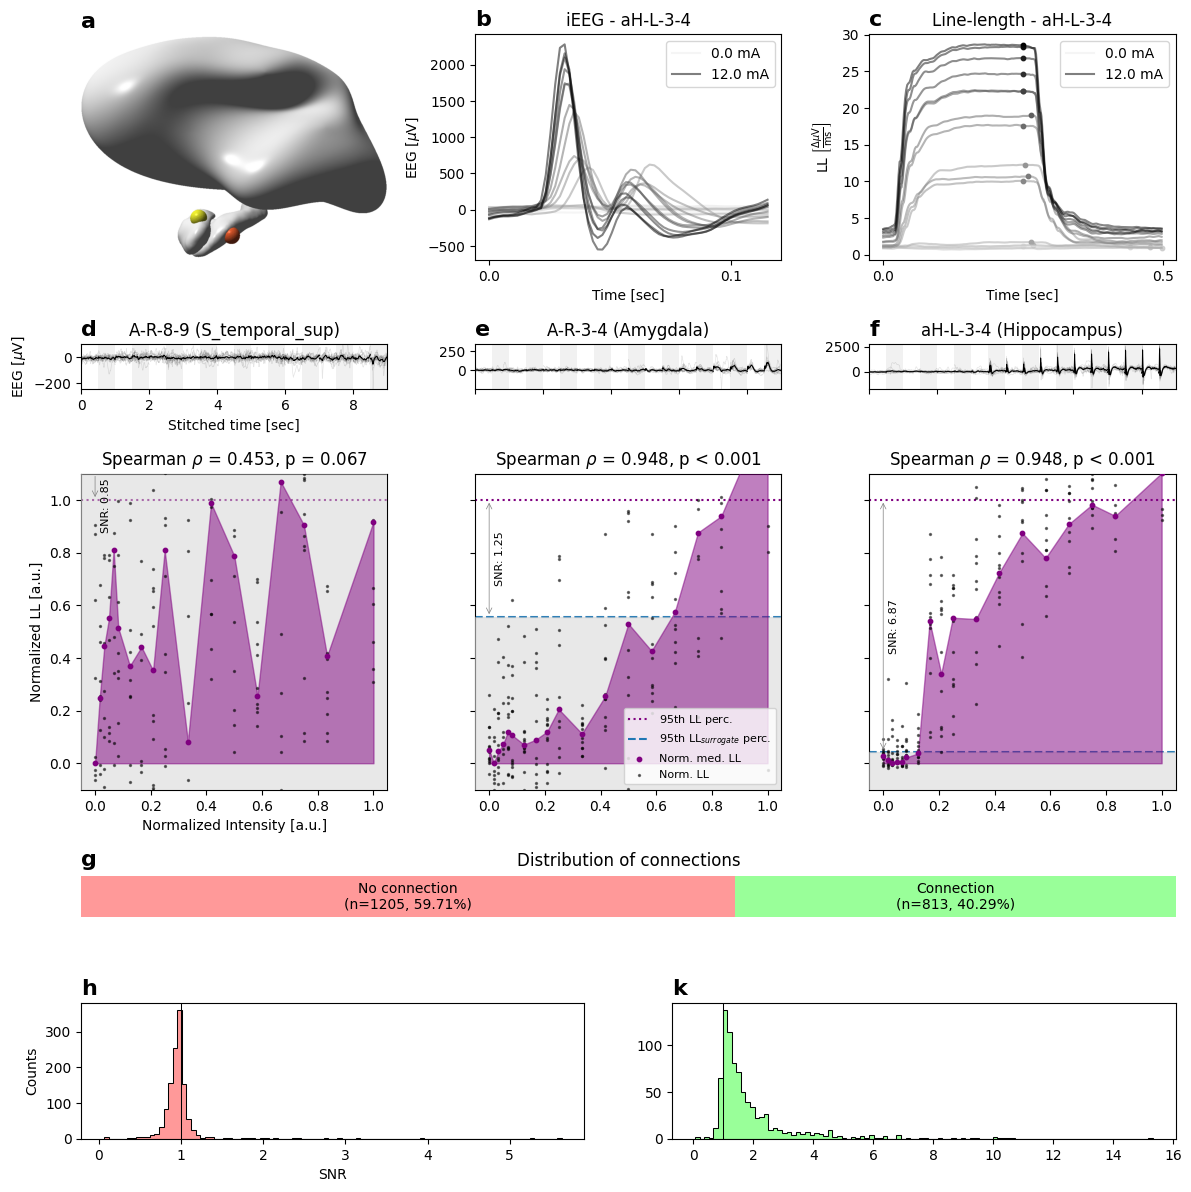

In [ ]:
# raw traces
import matplotlib.image as mpimg
from connectivity.analyze import (
    calculate_continuous_line_length,
    filter_logs,
    normalize_ll_values,
)
from connectivity.enums import SleepStage
from connectivity.load import MultipleHDFResponseLoader, get_h5_names_of_patient

stim_channel_name_pos = "A-L-3"
stim_channel_name_neg = "A-L-4"
stim_channel_name = stim_channel_name_pos + "-" + stim_channel_name_neg

# response_channel_name_pos = "CinG-L-1"
# response_channel_name_pos = "pH-L-4"
# response_channel_name_pos
response_channel_pairs = [

    ("A-R-8", "A-R-9"),  # no response
    ("A-R-3", "A-R-4"), # Late increase
    ("aH-L-3", "aH-L-4"),  # Floor
    #("aH-L-1", "aH-L-2"),  # GO DOWN

    #("pH-L-8", "pH-L-9"), # weak
    #("aI-L-10", "aI-L-11"),   
]
friendly_response_channel_names = [
    "A-R-8-9",
    "A-R-3-4",
    "aH-L-3-4"
]
# response_channel_name_neg = "CinG-L-2"
# response_channel_name_neg = "pH-L-5"
# response_channel_name_neg = "aI-L-4"

def format_p(p):
    return "p < 0.001" if p < 0.001 else f"p = {p:.3f}"


names_h5 = get_h5_names_of_patient(base_path, patient_id, protocol="CR", new_overview_format=True)
path_lookup = f"{base_path}/{patient_id}/Electrodes/Lookup.xlsx"
paths_h5 = [f"{base_path}/{patient_id}/Electrophy/{name}.h5" for name in names_h5]
paths_logs = [f"{base_path}/{patient_id}/out/{name}_logs.csv" for name in names_h5]
path_excluded_responses = f"{base_path}/{patient_id}/{CLEAN_DATA_FILE}"

mrl = MultipleHDFResponseLoader(
    paths_h5=paths_h5,
    paths_logs=paths_logs,
    recording_names=names_h5,
    path_lookup=path_lookup,
    path_excluded_responses=path_excluded_responses,
)

mrl.add_sleep_score_to_logs()
logs = mrl.get_logs()

ll_matrix = np.load(
    NULL_DISTRIBUTION_FILE, allow_pickle=True
)  # shape: n_surrogates, n_intensities, n_replications, n_response_channels
all_response_channels = mrl.get_channel_paths(
    exclude_noisy_channels=True,
    exclude_stim_channels=True,
    stim_channel_name_pos=stim_channel_name_pos,
    stim_channel_name_neg=stim_channel_name_neg,
    exclude_out_channels=True,
    exclude_wm_only_channels=True
)
assert ll_matrix.shape[3] == len(
    all_response_channels
), "The number of response channels in the null distribution does not match the number of response channels in the data."

responses_df = pd.read_json(RESPONSES_FILE, orient="records")
responses_df = responses_df[responses_df["patient_id"].isin(allowed_ids)]

curve_fitting_df = pd.read_json(CURVE_FITTING_FILE, orient="records")
curve_fitting_df = curve_fitting_df[curve_fitting_df["patient_id"].isin(allowed_ids)]
responses_df

merged_df = pd.merge(
    responses_df,
    curve_fitting_df,
    on=["patient_id", "stim_channel_name", "response_channel_name"],
    how="left"
)
merged_df["is_sigmoidal"] = merged_df[main_curve + "_" + "r_squared"] >= R_SQUARED_THRESHOLD



def plot_stimulation_response_curve(
    stim_channel_name_pos,
    stim_channel_name_neg,
    response_channel_pair,
    ax_u,
    ax_ll,
):
    response_channel_name_pos = response_channel_pair[0]
    response_channel_name_neg = response_channel_pair[1]
    response_channel_name = response_channel_name_pos + "-" + response_channel_name_neg

    stim_channel_name = stim_channel_name_pos + "-" + stim_channel_name_neg

    response_channel_path = mrl.get_channel_paths_from_names(
        channel_names=[response_channel_name]
    )[0]
    
    result_dict = merged_df[
        (merged_df["patient_id"] == patient_id) &
        (merged_df["stim_channel_name"] == stim_channel_name) &
        (merged_df["response_channel_name"] == response_channel_name)
    ].squeeze()


    io_stimlist = filter_logs(
        complete_logs=logs,
        n_replications=12,
        selected_stim_channel_name_pos=stim_channel_name_pos,
        selected_stim_channel_name_neg=stim_channel_name_neg,
        sleep_stages=[SleepStage.AWAKE, SleepStage.QWAKE],
    )

    io_intensities = (
        logs[logs["type"] == "CR_IO"]["Int_prob"].drop_duplicates().tolist()
    )
    io_intensities.sort()
    io_intensities.insert(0, 0)

    # RAW TRACES
    id_matrix = result_dict["id_matrix"]
    id_matrix = np.array(id_matrix)  # shape: n_intensities, n_replications
    ind_matrix = mrl.get_inds_from_stim_ids(id_matrix)

    ll_window_start = round(
        1 * mrl.f_sample
    )  # we only want to have the [0, 0.5s] window to display, as it is used for LL calculation
    ll_window_end = round(1.5 * mrl.f_sample)
    chunk_len = ll_window_end - ll_window_start  # traces.shape[3]
    total_chunks = id_matrix.shape[0]
    time = np.arange(chunk_len * total_chunks) / mrl.f_sample

    # Plot each chunk with color-coded significance
    for j in range(total_chunks):
        if j == 0:
            # remove the -0.6s in the end of every index that indicates baseline
            cleaned_ids = [s.replace("-0.6s", "") for s in id_matrix[j]]
            cleaned_inds = mrl.get_inds_from_stim_ids(cleaned_ids)

            traces = mrl.get_responses(
                stim_indices=cleaned_inds,
                response_channel_paths=[response_channel_path],
                t_start=-1-0.6,
                t_stop=1-0.6,
                overwrite_excluded_recordings=True, 
            ).squeeze(
                1
            )  # shape: n_replications, 1, n_time,

            traces_chunk = traces[:, ll_window_start:ll_window_end]
        else:
            traces = mrl.get_responses(
                stim_indices=ind_matrix[j],
                response_channel_paths=[response_channel_path],
                # overwrite_excluded_recordings=exclude_responses,
                t_start=-1,
                t_stop=1,
                overwrite_excluded_recordings=True,
            ).squeeze(
                1
            )  # shape: n_replications, 1, n_time, remove middle dim
            traces_chunk = traces[:, ll_window_start:ll_window_end]
        avg_trace_chunk = np.nanmean(traces_chunk, axis=0)  # shape: n_time

        start_idx = j * chunk_len
        end_idx = (j + 1) * chunk_len
        time_chunk = time[start_idx:end_idx]

        for trace in traces_chunk:
            ax_u.plot(time_chunk, trace, color="black", alpha=0.1, linewidth=0.5)
        ax_u.plot(
            time_chunk,
            avg_trace_chunk,
            color="black",
            linewidth=0.75,
        )

        start = start_idx / mrl.f_sample
        end = end_idx / mrl.f_sample
        ax_u.axvspan(
            start,
            end,
            facecolor=("lightgray" if j % 2 else "white"),
            alpha=0.3,
            zorder=0,
        )
    ax_u.margins(x=0, y=0)

    # STIMULATION RESPONSE CURVE
    norm_intensities = np.array(io_intensities) / max(io_intensities)
    norm_med_lls = np.array(result_dict["norm_med_lls"])
    med_lls = np.array(result_dict["med_lls"])

    shared_ll_min = np.nanmin(result_dict["med_lls"], axis=0)
    shared_ll_max = np.nanpercentile(result_dict["med_lls"], 95, axis=0)
    norm_lls = normalize_ll_values(
        ll_values=result_dict["ll_values"],
        max=shared_ll_max,
        min=shared_ll_min,
        use_min=True,
        axis=0,
    )

    surr_percentile = result_dict["surrogates_percentiles_med"]["95"]
    norm_surr_percentile = (surr_percentile - np.min(med_lls)) / (np.percentile(med_lls, q=95) - np.min(med_lls))

    percentile_95 = np.nanpercentile(norm_med_lls, q=95)
    ax_ll.axhline(percentile_95, linestyle=":", color="purple", label="95th $\\mathrm{LL}$ perc.")
    ax_ll.axhline(norm_surr_percentile, linestyle="dashed", label="95th $\\mathrm{LL}_{surrogate}$ perc.")

    ax_ll.scatter(
        norm_intensities, norm_med_lls, color="purple", s=10, label="Norm. med. LL", zorder=7
    )
    for j in range(norm_lls.shape[1]):
        ax_ll.scatter(norm_intensities, norm_lls[:, j], color="black", alpha=0.5, s=2, zorder=6, label="Norm. LL" if j==0 else "_nolegend_")

    ax_ll.fill_between(norm_intensities, norm_med_lls, y2=0, color='purple', alpha=0.5, zorder=5)
    # ax_ll.fill_between(norm_intensities, norm_med_lls, color="purple", alpha=0.2, label=f"ExI: {real_exi: .2f}")
    # ax_ll.set_ylim(bottom=0)
    ax_ll.set_title(f"Spearman $\\rho$ = {result_dict['spearman_rho']:.3f}, {format_p(result_dict['spearman_p_value_fdr_corrected'])}")
    
    # double arrow
    arrow_pos = 0 # x position where the arrow will be drawn
    if np.abs(percentile_95 - norm_surr_percentile) > 0.2 and percentile_95 < 1.1 and norm_surr_percentile < 1.1: # only display double array if there is some space to do so
        ax_ll.annotate(
            '', 
            xy=(arrow_pos, percentile_95), 
            xytext=(arrow_pos, norm_surr_percentile),
            arrowprops=dict(arrowstyle='<->', color='gray', lw=0.5),
            zorder=10
        )
        label_y = (percentile_95 + norm_surr_percentile) / 2
        ax_ll.text(arrow_pos + 0.02, label_y, f"SNR: {result_dict['snr']:.2f}", va='center', ha='left', color='black', fontsize=8, rotation=90, zorder=10)
    else:
        ax_ll.annotate(
            '', 
            xy=(arrow_pos, percentile_95), 
            xytext=(arrow_pos, 1.1),
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            zorder=10
        )
        ax_ll.text(0 + 0.02, 0.98, f"SNR: {result_dict['snr']:.2f}", va='center', ha='left', color='black', fontsize=8, rotation=90, zorder=10)

    # gray below 95th
    x_min, x_max = ax_ll.get_xlim()
    # Fill below the line
    ax_ll.axhspan(ax_ll.get_ylim()[0], norm_surr_percentile, color='lightgray', alpha=0.5, zorder=3)


def plot_panel_g(ax_l):
    no_connection = len(merged_df[merged_df["is_significant"] != True])
    connection = len(merged_df[(merged_df["is_significant"] == True)])

    values = [no_connection, connection]
    total = no_connection + connection
    labels = [
        f"No connection\n(n={no_connection}, {no_connection/total:.2%})",
        f"Connection\n(n={connection}, {connection/total:.2%})"
    ]
    colors = ["#FF9999", "#99FF99"]

    # Stacked horizontal bar
    ax_l.barh(0, values[0], color=colors[0], label=labels[0])
    ax_l.barh(0, values[1], left=values[0], color=colors[1], label=labels[1])
    ax_l.text(values[0] / 2, 0, labels[0],
          ha="center", va="center", fontsize=10)

    ax_l.text(values[0] + values[1] / 2, 0, labels[1],
          ha="center", va="center", fontsize=10)

    # Formatting
    ax_l.set_xlim(0, sum(values))
    ax_l.set_axis_off()
    ax_l.set_title("Distribution of connections")


def plot_panel_b_and_c(ax_b, ax_c, response_channel_name):
    response_channel_path = mrl.get_channel_paths_from_names(
        channel_names=[response_channel_name]
    )[0]
    # RAW TRACES
    result_dict = merged_df[
        (merged_df["patient_id"] == patient_id) &
        (merged_df["stim_channel_name"] == stim_channel_name) &
        (merged_df["response_channel_name"] == response_channel_name)
    ].squeeze()
    id_matrix = result_dict["id_matrix"]
    id_matrix = np.array(id_matrix)  # shape: n_intensities, n_replications
    ind_matrix = mrl.get_inds_from_stim_ids(id_matrix)

    ll_window_start = round(
        1 * mrl.f_sample
    )  # we only want to have the [0, 0.5s] window to display, as it is used for LL calculation
    ll_max_window_offset = round(0.25 * mrl.f_sample) # max is taken from [0.25, 5s]
    ll_window_end = round(1.5 * mrl.f_sample)
    chunk_len = ll_window_end - ll_window_start  # traces.shape[3]
    total_chunks = id_matrix.shape[0]
    time = np.arange(chunk_len * total_chunks) / mrl.f_sample - 1
    avg_traces = []
    cmap = plt.cm.Greys
    # Plot each chunk with color-coded significance
    for j in range(total_chunks):
        if j == 0:
            # remove the -0.6s in the end of every index that indicates baseline
            cleaned_ids = [s.replace("-0.6s", "") for s in id_matrix[j]]
            cleaned_inds = mrl.get_inds_from_stim_ids(cleaned_ids)

            traces = mrl.get_responses(
                stim_indices=cleaned_inds,
                response_channel_paths=[response_channel_path],
                t_start=-1-0.6,
                t_stop=1-0.6,
                overwrite_excluded_recordings=True, 
            ).squeeze(
                1
            )  # shape: n_replications, 1, n_time,

            traces_chunk = traces[:, ll_window_start:ll_window_end]
        else:
            traces = mrl.get_responses(
                stim_indices=ind_matrix[j],
                response_channel_paths=[response_channel_path],
                # overwrite_excluded_recordings=exclude_responses,
                t_start=-1,
                t_stop=1,
                overwrite_excluded_recordings=True,
            ).squeeze(
                1
            )  # shape: n_replications, 1, n_time, remove middle dim
            traces_chunk = traces[:, ll_window_start:ll_window_end]
        avg_trace_chunk = np.nanmean(traces_chunk, axis=0)  # shape: n_time

        cont_ll_avg = calculate_continuous_line_length(
            data=np.nanmean(traces, axis=0),
            start_index=ll_window_start,
            end_index=ll_window_end,
            window_width_indices=round(0.25 * mrl.f_sample),
            f_sample=mrl.f_sample
        )

        
        max_idx = (
            cont_ll_avg[ll_max_window_offset:].argmax() + ll_max_window_offset
        )
        
        intensities = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0])
        ax_b.plot(time[ll_window_start:ll_window_end][0:60], avg_trace_chunk[0:60], color=cmap((j+3)/20), alpha=0.5, label=f"{intensities[j]} mA" if ((j==0) or (j==17)) else "_nolegend_")
        ax_c.plot(time[ll_window_start:ll_window_end], cont_ll_avg, color=cmap((j+3)/20), alpha=0.5, label=f"{intensities[j]} mA" if ((j==0) or (j==17)) else "_nolegend_")
        ax_c.scatter(time[ll_window_start:ll_window_end][max_idx], cont_ll_avg[max_idx], color=cmap((j+3)/20), s=10)

    ax_b.legend()
    ax_b.set_xlabel("Time [sec]")
    ax_b.set_ylabel("EEG $\\left[\\mu \\mathrm{V}\\right]$")
    ax_b.set_xticks([0, 0.1])
    ax_c.legend()
    ax_c.set_xlabel("Time [sec]")
    ax_c.set_ylabel("LL $\\left[\\frac{\\Delta\\mu \\mathrm{V}}{\\mathrm{ms}}\\right]$")
    ax_c.set_xticks([0, 0.5])

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(
    5, 6, figure=fig, height_ratios=[5, 1, 7, 1, 3]
)
    

ax_a = fig.add_subplot(gs[0, 0:2])
ax_a.set_title("a", loc='left', fontsize=16, fontweight='bold')
img = mpimg.imread("inflated_brain_2.PNG")
ax_a.imshow(img)
ax_a.axis("off")
ax_b = fig.add_subplot(gs[0, 2:4])
ax_b.set_title("b", loc='left', fontsize=16, fontweight='bold')
ax_b.set_title("iEEG - aH-L-3-4")
ax_c = fig.add_subplot(gs[0, 4:])
ax_c.set_title("c", loc='left', fontsize=16, fontweight='bold')
ax_c.set_title("Line-length - aH-L-3-4")

plot_panel_b_and_c(ax_b=ax_b, ax_c=ax_c, response_channel_name="aH-L-3-aH-L-4")

grid_rows = [1, 1, 1]
grid_cols = [0, 2, 4]
names = ["d", "e", "f"]

first_ax_ll = None
first_ax_lr = None
for j, name in enumerate(names):
    ax_u = fig.add_subplot(gs[grid_rows[j], grid_cols[j]:(grid_cols[j]+2)])
    ax_u.set_title(name, loc='left', fontsize=16, fontweight='bold')
    resp_channel_name = "-".join(response_channel_pairs[j])
    destr_label = mrl.get_destrieux_labels_from_names(channel_names=[resp_channel_name], short_form=True)[0]
    ax_u.set_title(f"{friendly_response_channel_names[j]} ({destr_label})")
    
    ax_ll = fig.add_subplot(gs[grid_rows[j]+1, grid_cols[j]:(grid_cols[j]+2)], sharey=first_ax_ll)
    ax_ll.set_ylim([-0.1, 1.1])

  
    if j == 0:
        first_ax_ll = ax_ll
    else:
        plt.setp(ax_ll.get_yticklabels(), visible=False)

    plot_stimulation_response_curve(
        stim_channel_name_pos=stim_channel_name_pos,
        stim_channel_name_neg=stim_channel_name_neg,
        response_channel_pair=response_channel_pairs[j],
        ax_u=ax_u,
        ax_ll=ax_ll
    )
    if j == 0:
        ax_ll.set_ylabel("Normalized LL [a.u.]")
        ax_ll.set_xlabel("Normalized Intensity [a.u.]")
        
        ax_u.set_ylabel("EEG $\\left[\\mu \\mathrm{V}\\right]$")
        ax_u.set_xlabel("Stitched time [sec]")
    else:
        plt.setp(ax_u.get_xticklabels(), visible=False)
    if j == 1:
        leg = ax_ll.legend(fontsize=8, loc="lower right")
        leg.set_zorder(12)  

ax_g = fig.add_subplot(gs[3, :])
ax_g.set_title("g", loc='left', fontsize=16, fontweight='bold')
plot_panel_g(ax_l=ax_g)


def plot_panel_h_and_k(ax_l, ax_r):
    significant_df = responses_df[responses_df["is_significant"] == True]
    not_significant_df = responses_df[responses_df["is_significant"] == False]

    ax_l.hist(not_significant_df["snr"], bins=100, color="#FF9999", histtype="stepfilled", edgecolor="black", linewidth=0.75)
    #ax_l.set_title("SNR distribution of non-connections")
    ax_l.axvline(1, color="black", linewidth=0.75)
    ax_r.hist(significant_df["snr"], bins=100, color="#99FF99", histtype="stepfilled", edgecolor="black", linewidth=0.75)
    #ax_r.set_title("SNR distribution of connections")
    ax_r.axvline(1, color="black", linewidth=0.75)


ax_h = fig.add_subplot(gs[4, :3])
ax_h.set_title("h", loc='left', fontsize=16, fontweight='bold')
ax_h.set_ylabel("Counts")
ax_h.set_xlabel("SNR")
ax_k = fig.add_subplot(gs[4, 3:])
ax_k.set_title("k", loc='left', fontsize=16, fontweight='bold')
plot_panel_h_and_k(ax_l=ax_h, ax_r=ax_k)


fig.tight_layout(rect=[0, 0, 1, 1], pad=1.0, h_pad=1.2, w_pad=1.2)

plt.savefig("../output/figures/figure1.pdf", bbox_inches='tight', dpi=300)
plt.savefig("../output/figures/figure1.svg", bbox_inches='tight', dpi=300)
plt.show()

In [3]:

#and found that 81.3\% significant connections had an SNR > 1.05 with highest SNRs around 9 (95th percentile).

connections = responses_df[responses_df["is_significant"] == True]

high_snr = connections[connections["snr"] > 1.05]
low_snr = connections[connections["snr"] <= 1.05]

print(f"{len(high_snr)/len(connections): .2%}")


print(np.percentile(connections["snr"], q=95))

 81.30%
4.665147359339998
